In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

df_cash = pd.read_csv("project_dataset/extract - cash request - data analyst.csv")
# df_fees = pd.read_csv("project_dataset/extract - fees - data analyst - .csv")

df_cash.head()


,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
1,70,100.0,rejected,2019-12-10 19:50:12.34778+00,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
2,7,100.0,rejected,2019-12-10 19:13:35.82546+00,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
3,10,99.0,rejected,2019-12-10 19:16:10.880172+00,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
4,1594,100.0,rejected,2020-05-06 09:59:38.877376+00,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN


## Data Cleaning & Preprocessing

In [2]:
# Drop rows with missing user_id in cash
df_cash = df_cash.dropna(subset=['user_id'])

# Convert  date columns to real date time
df_cash['created_at'] = pd.to_datetime(df_cash['created_at'])

## Creating Cohorts

We define each user’s cohort as the month when they made their first cash advance.

In [3]:
# Create a cohort column (as Period: YYYY-MM)
df_cash['cohort_month'] = df_cash.groupby('user_id')['created_at'].transform('min').dt.to_period('M')

# Also create a column for the transaction’s month
df_cash['transaction_month'] = df_cash['created_at'].dt.to_period('M')

# Now create a cohort index: number of months since cohort start.
df_cash['cohort_index'] = (df_cash['transaction_month'] - df_cash['cohort_month']).apply(lambda x: x.n)

# Quick check:
df_cash[['user_id','created_at','cohort_month','transaction_month','cohort_index']].head(10)


/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_14445/1773421427.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_cash['cohort_month'] = df_cash.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_14445/1773421427.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_cash['transaction_month'] = df_cash['created_at'].dt.to_period('M')


,user_id,created_at,cohort_month,transaction_month,cohort_index
0,804.0,2019-12-10 19:05:21.596873+00:00,2019-12,2019-12,0
1,231.0,2019-12-10 19:50:12.347780+00:00,2019-12,2019-12,0
2,191.0,2019-12-10 19:13:35.825460+00:00,2019-12,2019-12,0
3,761.0,2019-12-10 19:16:10.880172+00:00,2019-12,2019-12,0
4,7686.0,2020-05-06 09:59:38.877376+00:00,2020-05,2020-05,0
5,9489.0,2020-05-23 20:58:55.129432+00:00,2020-05,2020-05,0
6,14631.0,2020-06-16 17:07:38.452652+00:00,2020-06,2020-06,0
9,897.0,2019-12-10 19:51:23.911206+00:00,2019-12,2019-12,0
10,2908.0,2020-02-08 19:20:44.627662+00:00,2020-02,2020-02,0
11,778.0,2020-05-14 21:11:47.393326+00:00,2019-12,2020-05,5


## Aggregating Metrics by Cohort and Month

1. **Usage Frequency:** Total number of requests per cohort & cohort index, and number of unique users.
2. **Incident Rate:** Rate of defined Incidents

In [4]:
# Add a helper column so that each transaction counts as 1
df_cash['usage_count'] = 1

# Defining incidents:
incident_statuses = ['rejected', 'canceled', 'direct_debit_rejected']
df_cash['incident'] = df_cash['status'].isin(incident_statuses).astype(int)

# Group by cohort_month and cohort_index
usage_summary = df_cash.groupby(['cohort_month', 'cohort_index']).agg(
    total_requests=('usage_count','sum'),
    unique_users=('user_id','nunique'),
    total_incidents=('incident','sum'),
    total_revenue=('amount','sum')
).reset_index()

# Calculate additional ratios
usage_summary['usage_frequency'] = usage_summary['total_requests'] / usage_summary['unique_users']
usage_summary['incident_rate'] = usage_summary['total_incidents'] / usage_summary['total_requests']


# Calculate the overall maximum cohort index
overall_max_index = usage_summary['cohort_index'].max()

# Filter out rows where the cohort_index is equal to the overall maximum
usage_summary = usage_summary[usage_summary['cohort_index'] < overall_max_index]

usage_summary.head(60)



,cohort_month,cohort_index,total_requests,unique_users,total_incidents,total_revenue,usage_frequency,incident_rate
0,2019-11,0,1,1,1,1.0,1.000000,1.000000
1,2019-11,1,1,1,1,100.0,1.000000,1.000000
2,2019-11,5,1,1,0,100.0,1.000000,0.000000
3,2019-11,6,1,1,0,10.0,1.000000,0.000000
4,2019-11,9,1,1,0,10.0,1.000000,0.000000
5,2019-11,10,1,1,0,5.0,1.000000,0.000000
7,2019-12,0,229,204,101,21757.0,1.122549,0.441048
8,2019-12,1,75,69,28,7163.0,1.086957,0.373333
9,2019-12,2,46,44,13,4441.0,1.045455,0.282609
10,2019-12,3,66,56,19,6350.0,1.178571,0.287879


## Aggregating Total Revenue


In [5]:
#creating a user_df as a copy of df_cash
user_df = df_cash.copy()

user_df = user_df.drop(columns=['id', 'status', 'updated_at',
       'moderated_at', 'deleted_account_id', 'reimbursement_date',
       'cash_request_received_date', 'money_back_date', 'transfer_type',
       'send_at', 'recovery_status', 'reco_creation', 'reco_last_update'])

#transforming the created_at column to datetime
user_df['created_at'] = pd.to_datetime(user_df['created_at'])

#aggregating to define the cohorts in form of df

first_requests = user_df.sort_values(by='created_at').drop_duplicates(subset='user_id', keep= 'first')
first_requests['created_at'] = first_requests['created_at'].dt.tz_localize(None) #this code avoids timezone issues while creating the cohort column
monthly_counts = first_requests['created_at'].dt.to_period('M').value_counts().sort_index()

#adding the cohort column to first_requests
first_requests['cohort'] = first_requests['created_at'].dt.to_period('M')

#creating the cohort_revenue variable

cohort_revenue = first_requests.groupby('cohort')['amount'].sum().reset_index() 

### Monthly Revenue Pivot Table

In [6]:
# Create a pivot table for monthly revenue

# Re-create cohort_data: Count the number of unique users per cohort month and cohort index
cohort_data = df_cash.groupby(['cohort_month', 'cohort_index'])['user_id'].nunique().reset_index()


# Create the pivot table
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='user_id')

# Drop the last column (assuming it's the incomplete month)
cohort_pivot = cohort_pivot.loc[:, cohort_pivot.columns < overall_max_index]

pivot_revenue = usage_summary.pivot(
    index='cohort_month', 
    columns='cohort_index', 
    values='total_revenue'
)

pivot_revenue

cohort_index,0,1,2,3,4,5,6,7,8,9,10
cohort_month,,,,,,,,,,,
2019-11,1.0,100.0,NaN,NaN,NaN,100.0,10.0,NaN,NaN,10.0,5.0
2019-12,21757.0,7163.0,4441.0,6350.0,6350.0,7095.0,7355.0,6140.0,7090.0,4610.0,6330.0
2020-01,9864.0,2060.0,1460.0,3500.0,2620.0,2370.0,2710.0,2150.0,1970.0,2300.0,100.0
2020-02,8000.0,4640.0,4527.0,4300.0,4055.0,3655.0,4250.0,2555.0,3795.0,NaN,NaN
2020-03,7520.0,3950.0,4040.0,4450.0,3455.0,2840.0,2550.0,2700.0,50.0,NaN,NaN
2020-04,22336.0,12478.0,12630.0,9500.0,9135.0,6915.0,6250.0,NaN,NaN,NaN,NaN
2020-05,38221.0,26168.0,22300.0,18664.0,14400.0,14605.0,300.0,NaN,NaN,NaN,NaN
2020-06,154933.0,83787.0,76441.0,56170.0,53850.0,350.0,NaN,NaN,NaN,NaN,NaN
2020-07,157294.0,70728.0,46555.0,45800.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN


### Revenue Table

In [7]:
# Create pivot table for usage frequency
pivot_usage_frequency = usage_summary.pivot(
    index='cohort_month', 
    columns='cohort_index', 
    values='usage_frequency'
)

# Display the pivot table
print("Usage Frequency (requests per unique user):")
pivot_usage_frequency

Usage Frequency (requests per unique user):


cohort_index,0,1,2,3,4,5,6,7,8,9,10
cohort_month,,,,,,,,,,,
2019-11,1.000000,1.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.00000
2019-12,1.122549,1.086957,1.045455,1.178571,1.245283,1.121212,1.288136,1.211538,1.206349,1.190476,1.20339
2020-01,1.122222,1.105263,1.071429,1.296296,1.173913,1.041667,1.037037,1.047619,1.100000,1.043478,1.00000
2020-02,1.071429,1.090909,1.170732,1.073171,1.105263,1.027778,1.250000,1.080000,1.200000,NaN,NaN
2020-03,1.130435,1.114286,1.281250,1.048780,1.133333,1.071429,1.038462,1.111111,1.000000,NaN,NaN
2020-04,1.080189,1.259615,1.231481,1.154762,1.302632,1.181818,1.237288,NaN,NaN,NaN,NaN
2020-05,1.108401,1.207048,1.202020,1.221557,1.218750,1.114865,1.000000,NaN,NaN,NaN,NaN
2020-06,1.239163,1.328551,1.250725,1.181481,1.147601,1.000000,NaN,NaN,NaN,NaN,NaN
2020-07,1.341577,1.325077,1.169421,1.115460,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


### Usage Frequency Pivot Table

In [8]:
# Create pivot table for usage frequency
pivot_usage_frequency = usage_summary.pivot(
    index='cohort_month', 
    columns='cohort_index', 
    values='usage_frequency'
)

# Display the pivot table
print("Usage Frequency (requests per unique user):")
pivot_usage_frequency

Usage Frequency (requests per unique user):


cohort_index,0,1,2,3,4,5,6,7,8,9,10
cohort_month,,,,,,,,,,,
2019-11,1.000000,1.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.00000
2019-12,1.122549,1.086957,1.045455,1.178571,1.245283,1.121212,1.288136,1.211538,1.206349,1.190476,1.20339
2020-01,1.122222,1.105263,1.071429,1.296296,1.173913,1.041667,1.037037,1.047619,1.100000,1.043478,1.00000
2020-02,1.071429,1.090909,1.170732,1.073171,1.105263,1.027778,1.250000,1.080000,1.200000,NaN,NaN
2020-03,1.130435,1.114286,1.281250,1.048780,1.133333,1.071429,1.038462,1.111111,1.000000,NaN,NaN
2020-04,1.080189,1.259615,1.231481,1.154762,1.302632,1.181818,1.237288,NaN,NaN,NaN,NaN
2020-05,1.108401,1.207048,1.202020,1.221557,1.218750,1.114865,1.000000,NaN,NaN,NaN,NaN
2020-06,1.239163,1.328551,1.250725,1.181481,1.147601,1.000000,NaN,NaN,NaN,NaN,NaN
2020-07,1.341577,1.325077,1.169421,1.115460,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


## New Metric – User Retention Rate

We propose to calculate the **retention rate** for each cohort – that is, the percentage of users from the original cohort who are still active (make at least one transaction) in each subsequent month.

In [9]:
# First, determine the number of users in each cohort at month 0 (the cohort start).
cohort_sizes = df_cash.groupby('cohort_month')['user_id'].nunique().reset_index()
cohort_sizes.columns = ['cohort_month', 'cohort_size']

# Next, create a pivot table that counts unique users by cohort and cohort_index
cohort_data = df_cash.groupby(['cohort_month', 'cohort_index'])['user_id'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='user_id')

# Divide each cell by the cohort_size to get retention percentages
retention = cohort_pivot.divide(cohort_sizes.set_index('cohort_month')['cohort_size'], axis=0)

# Show retention table
retention.round(2)

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2019-11,1.0,1.00,NaN,NaN,NaN,1.00,1.00,NaN,NaN,1.00,1.00,1.0
2019-12,1.0,0.34,0.22,0.27,0.26,0.32,0.29,0.25,0.31,0.21,0.29,0.0
2020-01,1.0,0.21,0.16,0.30,0.26,0.27,0.30,0.23,0.22,0.26,0.01,NaN
2020-02,1.0,0.52,0.49,0.49,0.45,0.43,0.43,0.30,0.42,NaN,NaN,NaN
2020-03,1.0,0.51,0.46,0.59,0.43,0.41,0.38,0.39,0.01,NaN,NaN,NaN
2020-04,1.0,0.49,0.51,0.40,0.36,0.31,0.28,NaN,NaN,NaN,NaN,NaN
2020-05,1.0,0.62,0.54,0.45,0.35,0.40,0.01,NaN,NaN,NaN,NaN,NaN
2020-06,1.0,0.52,0.52,0.40,0.41,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2020-07,1.0,0.50,0.37,0.39,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Visualization

## 1. User Frequency

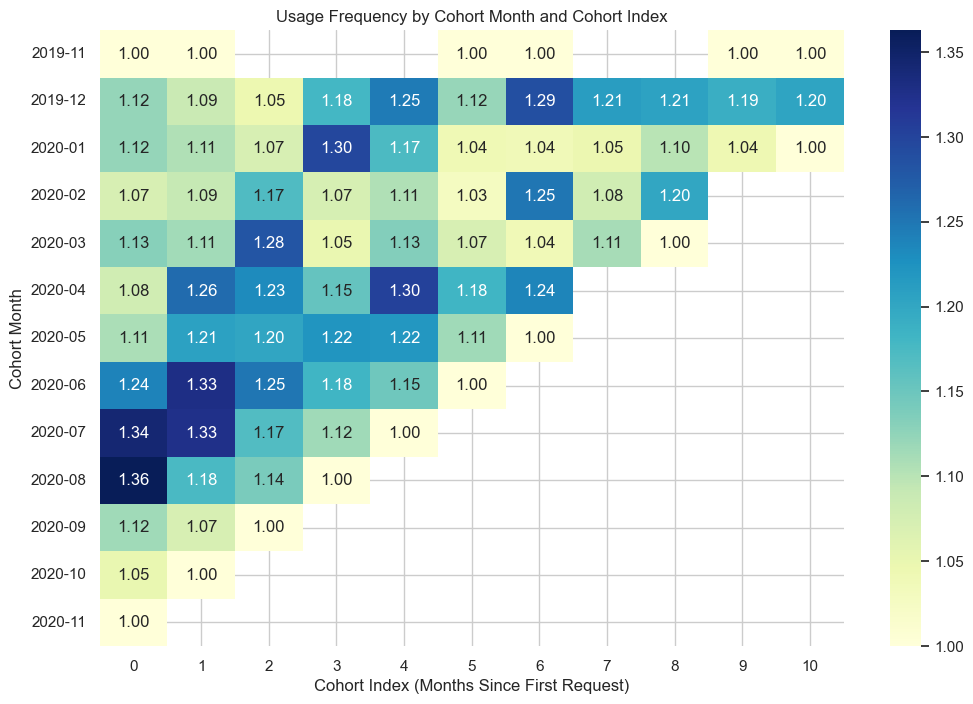

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_usage_frequency, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Usage Frequency by Cohort Month and Cohort Index")
plt.ylabel("Cohort Month")
plt.xlabel("Cohort Index (Months Since First Request)")
plt.show()


## 2. Bar chart for Revenue by Cohort

/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_14445/1413718502.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


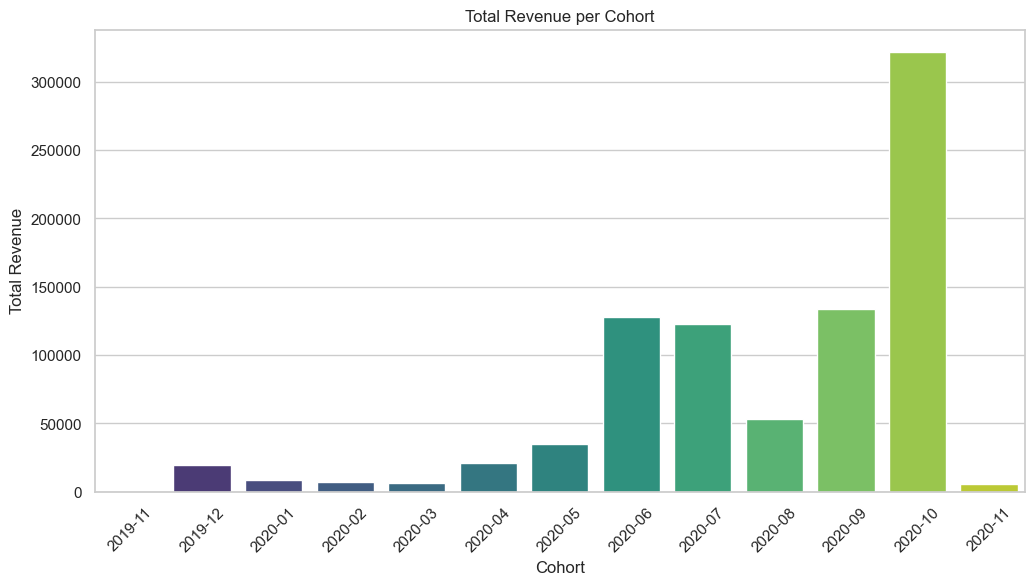

In [11]:
sns.barplot(
    x='cohort',
    y='amount',
    data=cohort_revenue,
    palette='viridis',
    )
plt.xticks(rotation=45)
plt.xlabel("Cohort")
plt.ylabel("Total Revenue")
plt.title("Total Revenue per Cohort")
plt.show()

## 2. Heatmap for Revenue by Cohort

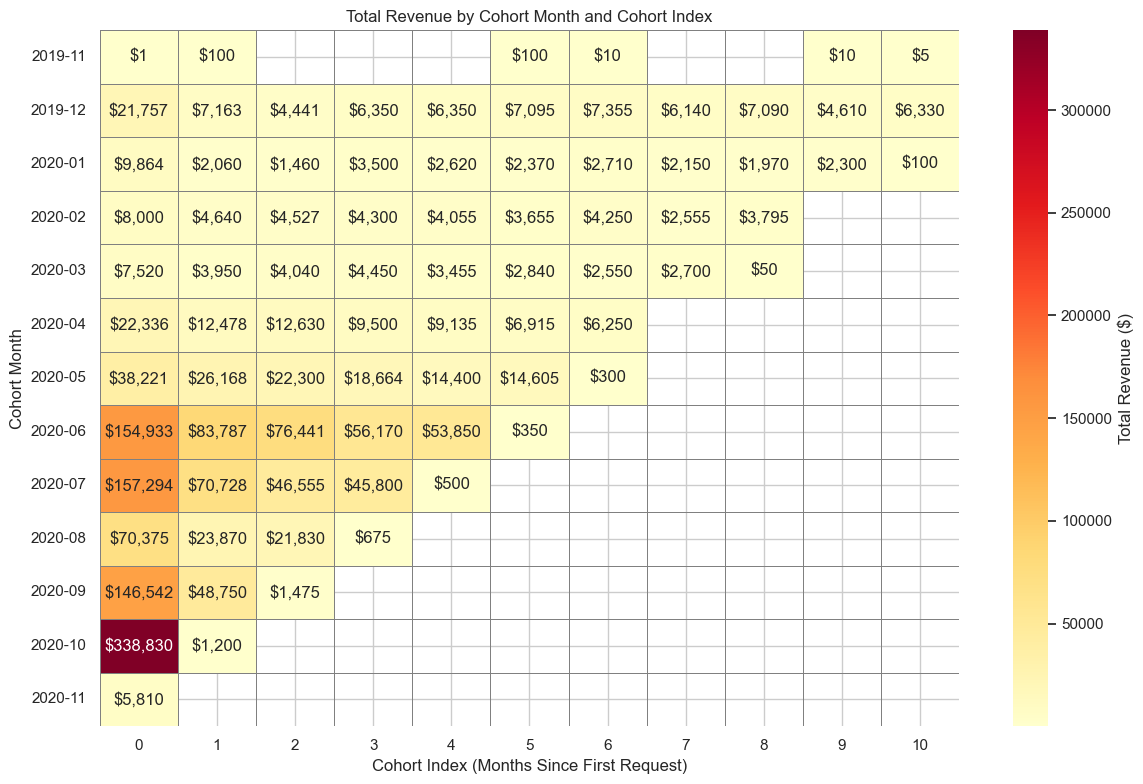

In [12]:

annot = pivot_revenue.map(lambda x: '' if pd.isna(x) else f'${x:,.0f}')
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_revenue, 
    annot=annot,        
    fmt='',            
    cmap="YlOrRd", 
    cbar_kws={'label': 'Total Revenue ($)'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Total Revenue by Cohort Month and Cohort Index")
plt.xlabel("Cohort Index (Months Since First Request)")
plt.ylabel("Cohort Month")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 3. Bar plot for Incident Rate by Cohort


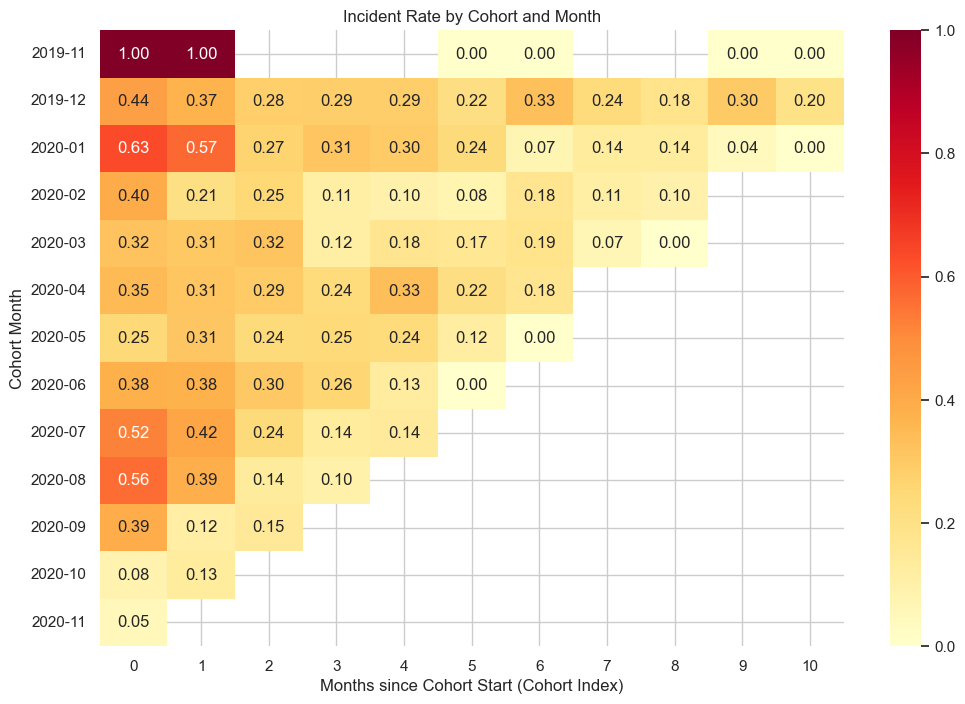

In [13]:
incident_rate_pivot = usage_summary.pivot(index='cohort_month', columns='cohort_index', values='incident_rate')

plt.figure(figsize=(12, 8))
sns.heatmap(incident_rate_pivot, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Incident Rate by Cohort and Month")
plt.xlabel("Months since Cohort Start (Cohort Index)")
plt.ylabel("Cohort Month")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


## 4. Heatmap of user retention rates

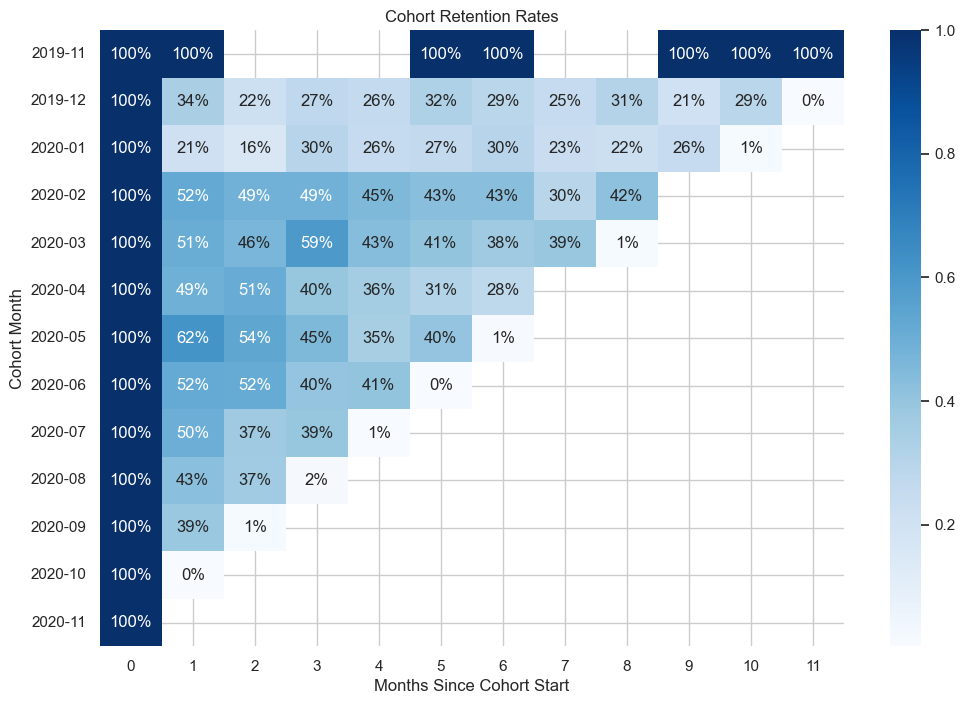

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Retention Rates')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since Cohort Start')
plt.show()